# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4: Линейные модели, введение в конкурсную задачу


###### <hr\>
**Общая информация**

**Срок сдачи:** 17 апреля 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 17 апреля, -4 балла после 06:00 24 апреля, -6 баллов после 06:00 1 мая

Имеется ввиду именно сдача данного ДЗ, а не конечного результата по конкурсу (см ниже).<br\>
Жесткий дедлайн по конкурсной задаче - 14 мая 23:59 GMT.

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [16]:
USER_NAME = u"Новикова".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print "Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
)

Имплементируйте обучение логистической регрессии с L2 регуляризацией с помощью метода Mini Batch Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Считать градиент по мини батчам
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в выборке (тем или иным способом)

# Реализация модели

## Имплементация (6 баллов)

In [27]:
from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    
    def __init__(self, C=1, alpha=0.01, max_epoch=10, random_state=None):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.random_state = random_state
    
    def fit(self, X, y=None):

        X = np.c_[np.ones(X.shape[0]), X] # столбец с единицами - для свободного члена (в начало Х)

        y[y == 0] = -1
        
        np.random.seed(self.random_state)
        #self.beta = np.random.rand(X.shape[1])
        self.beta = np.zeros(X.shape[1], dtype=np.float64)
        new_beta = np.zeros(X.shape[1], dtype=np.float64)
        self.errors = []
        
        X_pd = pd.DataFrame(X)
        
        for epoch in xrange(1, self.max_epoch + 1):
            mesh = np.random.permutation(X.shape[0])
            X = X[mesh]
            y = y[mesh]
            #h1 = 2
            #h2 = 5
            for step in xrange(X.shape[0]):
                #ind_1 = np.random.choice(X.shape[0] - 10)
                #ind_2 = ind_1 + 5
                #X_items = X[ind_1:ind_2]
                #y_items = y[ind_1:ind_2]
                if step <  X.shape[0] - 5:
                    X_items = X[step: step + 5]
                    y_items = y[step: step + 5]
                else:
                    X_items = X[step - 5: step]
                    y_items = y[step-5: step]
                #items = [X_pd.loc[i] for i in ind]
                new_beta += (self.alpha / epoch) * self.grad_func(X_items, y_items, self.beta)
                np.copyto(self.beta, new_beta)  
            self.count_error(X, y, self.beta)
        
        return self
    
    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
    
        return self
        
    def predict(self, X):
        '''
        Возвращение метки класса
        lbl = sign(g(x))
        '''
        X = np.c_[np.ones(X.shape[0]), X] # столбец с единицами - для свободного члена (в начало Х)

        y_res = np.sign(np.dot(self.beta, X.T))
        y_res[y_res == 0] = 1
        
        return y_res
    
    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        P = sigma(g(x))
        '''
        X = np.c_[np.ones(X.shape[0]), X] # столбец с единицами - для свободного члена (в начало Х)
        
        return 1 / (1 + np.exp(np.dot(self.beta, X.T)))
    
    def grad_func(self, X, y, beta):
        '''
        Градиент ф-ции потерь, рассчитанный по одной точке 
        ''' 
        #градиент без учета регуляризации
        grad = np.zeros(len(X))
            
        grad_1 = X[0]*y[0]/(1 + np.exp(y[0]*np.dot(X[0], beta.T))) 
        grad_2 = X[1]*y[1]/(1 + np.exp(y[1]*np.dot(X[1], beta.T))) 
        grad_3 = X[2]*y[2]/(1 + np.exp(y[2]*np.dot(X[2], beta.T)))
        grad_4 = X[3]*y[3]/(1 + np.exp(y[3]*np.dot(X[3], beta.T)))
        grad_5 = X[4]*y[4]/(1 + np.exp(y[4]*np.dot(X[4], beta.T)))
        grad = grad_1 + grad_2 + grad_3 + grad_4 + grad_5
        
        #for i in range(len(X)):
        #    grad_without_regul += (X[i]*y[i]/(1 + np.exp(y[i]*np.dot(X[i], beta.T)))) 
        
        
        #убираем из регуляризации свободный член
        #beta[0] = 0
        return grad - self.C * 2 * beta
    
    def count_error(self, X, y, beta):
        '''
        Вычисляет долю неверно классифицированных объектов
        '''
        lbl = y*np.dot(beta, X.T)
        self.errors.append(float(len(lbl[lbl < 0]))/X.shape[0])
        return

## Проверка на синтетических данных (2 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

Weights: [ 2.45234177  1.11654069 -2.02095839]


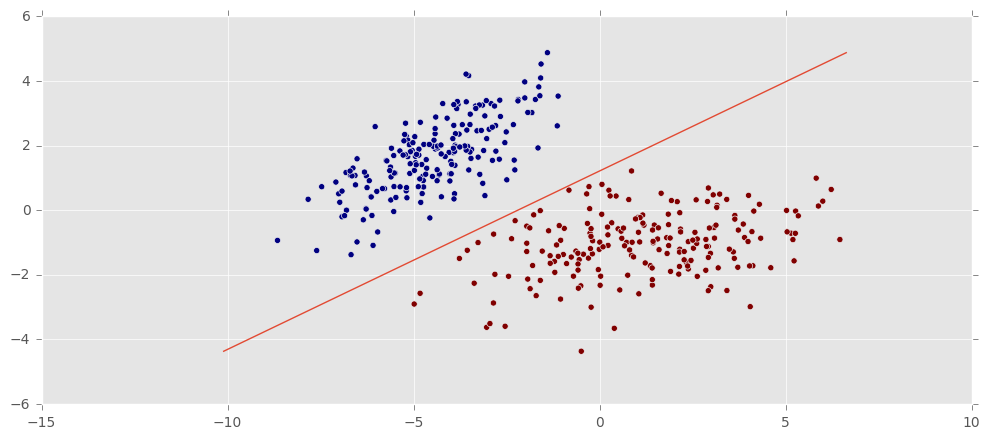

In [28]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([-5, -3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.zeros(200), np.ones(200)]


model = MySGDClassifier(max_epoch=10, alpha=0.5, C=0.01).fit(X, y)

print 'Weights:', model.beta

plt.scatter(X[:,0], X[:,1], c=y)
x_arr = np.array([X[:,0].min(), X[:,0].max()])
y_arr = np.array([X[:,1].min(), X[:,1].max()])
plt.plot(-(y_arr*model.beta[2] + model.beta[0]) / model.beta[1], y_arr) 

In [ ]:
model = MySGDClassifier()
model.fit(X, y)

In [ ]:
## Your Code Here

## Анализ сходимости (2 балл)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

Веса:
[ 4.60825098 -1.08742836  1.27073642]


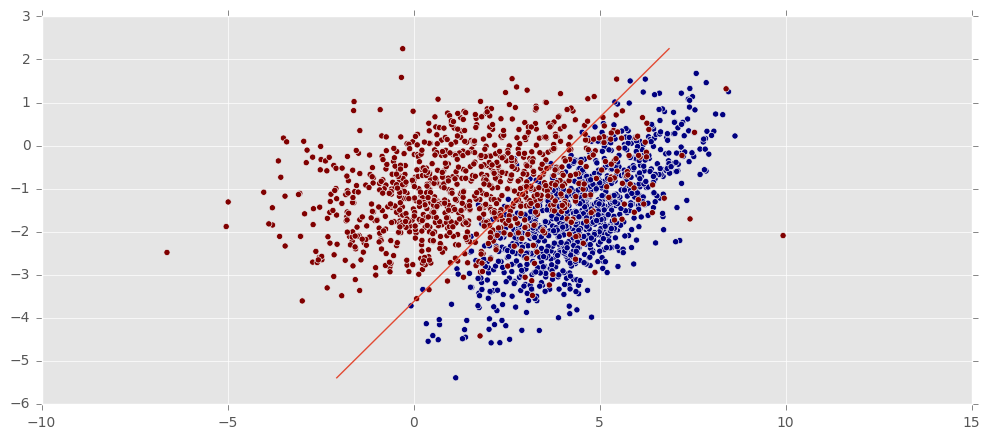

In [29]:
np.random.seed(0)


C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(1000, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(1000, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.zeros(1000), np.ones(1000)]


model = MySGDClassifier(max_epoch=10, alpha=0.2, C=0.01).fit(X, y)

print 'Веса:'
print model.beta

plt.scatter(X[:,0], X[:,1], c=y)
x_arr = np.array([X[:,0].min(), X[:,0].max()])
y_arr = np.array([X[:,1].min(), X[:,1].max()])
plt.plot(-(y_arr*model.beta[2]+model.beta[0])/model.beta[1], y_arr) 

Покажем на графике зависимости ошибки от количества эпох для значений alpha = (0.5, 0.05, 0.005, 0.002). Мера ошибки - доля неправильно классифицированных объектов. Число эпох возьмем равное 100 (чтобы для всех alpha алгоритм сходился).

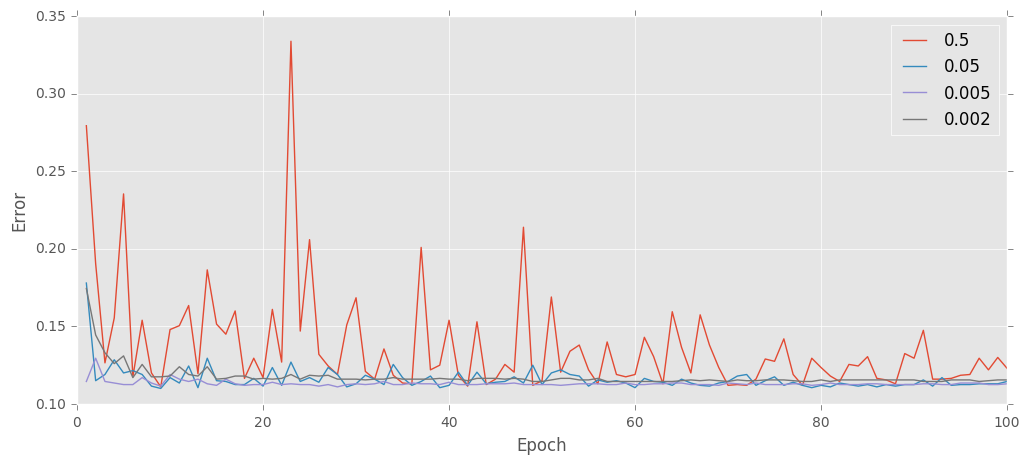

In [30]:
for alpha in (0.5, 0.05, 0.005, 0.002):
    model = MySGDClassifier(max_epoch=100, alpha=alpha, C=0.01).fit(X, y)
    plt.plot(xrange(1,101), model.errors, label=str(alpha))
plt.xlabel(u'Epoch')
plt.ylabel(u'Error')
plt.legend()

Видно, что оптимальные значения alpha 0.05 - 0.005. При alpha = 0.5 шаг слишком большой, поэтому мы перепрыгиваем экстремум, и видны скачки на графике. При alpha = 0.05 скачки тоже есть, но не такие большие.

# Введение в конкурсную задачу

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

### Правила
* Объединяться в команды по правилам конкурса можно, но по правилам нашего курса - нельзя)
* Вы можете использовать любой алгоритм, даже неизученный в нашем курсе (если на защите сможете объяснить как он работает)
* Имейте ввиду, что вы должны отправить результаты строго до 14 мая 23:59 GMT на сайт соревнования (раздел submission). Без результата в leaderboard оценка выставлена не будет.

## Данные

Для того, чтобы получить данные необходимо зарегистрироваться на сайте соревнования. 

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


Данные поставляются в двух форматах:
* В формате json содержится полная информация по текущему состоянию раунда
* В табличном формате упрощенная аггрерированная информация по текущему состоянию раунда

В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если данные не будут помещаться вам с оперативную память, рекомендуется совершить предобработку в python, а  моделирование выполнять с помощью [vowpal wabbit](https://github.com/JohnLangford/vowpal_wabbit).

In [46]:
# Загрузка одной части данных
filepath = '/Users/anastasianovikova/Sphere_DM/spheremailru-master/trainingData_tabular/trainingData_tabular_chunk3.csv'
df_data = pd.read_csv(filepath, sep=',')

In [36]:
# Загрузка данных целиком
df_list = []
for chunk in range(1,5):
    filepath = '/Users/anastasianovikova/Sphere_DM/spheremailru-master/trainingData_tabular/trainingData_tabular_chunk%d.csv' % chunk
    df_list.append(pd.read_csv(filepath, sep=','))

df_data = pd.concat(df_list)

In [47]:
df_data.shape

(500000, 45)

In [48]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [49]:
df_data.head().T

gamestate_id,4398318.0,4515958.0,2618902.0,4635943.0,2596956.0
decision,1,0,0,0,1
turn,3,17,13,5,16
opponent_armor,0,0,0,0,0
opponent_attack,3,0,0,0,3
opponent_hero_card_id,1235,612,390,754,754
opponent_hp,30,3,16,27,3
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,1,0,0,0,1
opponent_crystals_all,2,10,10,4,10
opponent_crystals_current,1,0,8,1,0


In [50]:
# Распределение классов
df_data.decision.mean()

# Примерно поровну

0.505828

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощьб one-hot кодирования, добавьте к датасету и удалите прежние столбцы

In [51]:
un_opp = df_data['opponent_hero_card_id'].unique()
print u'Уникальные карты оппонента:', un_opp
print u'Их число:', len(un_opp)
un_pl = df_data['player_hero_card_id'].unique()
print u'Уникальные карты игрока:', un_pl
print u'Их число:', len(un_pl)

Уникальные карты оппонента: [1235  612  390  754  326  981   25  798  494]
Их число: 9
Уникальные карты игрока: [ 494  612 1235   25  798  390  326  981  754]
Их число: 9


Преобразуем категориальные признаки - opponent_hero_card_id и player_hero_card_id. В этих полях могут быть 9 значений. Создадим для каждого из значений отдельную колонку, в которой для каждой игры будет стоять 0 или 1, в зависимости от того, эта ли карта используется в данной игре или нет:

In [52]:
from sklearn.preprocessing import OneHotEncoder

opponent = OneHotEncoder().fit_transform(df_data['opponent_hero_card_id'].values.reshape(-1, 1)).toarray().astype(int)
player = OneHotEncoder().fit_transform(df_data['player_hero_card_id'].values.reshape(-1, 1)).toarray().astype(int)

for i in xrange(len(opponent[0])):
    df_data['opponent_hero_card_{}'.format(i)] = opponent[:,i]
    df_data['player_hero_card_{}'.format(i)] = player[:,i]

In [53]:
# Удалим колонки opponent_hero_card_id и player_hero_card_id
df_data.drop(df_data[['opponent_hero_card_id', 'player_hero_card_id']], axis=1, inplace=True)

In [54]:
# Теперь наши данные выглядят так:
df_data.head().T

gamestate_id,4398318.0,4515958.0,2618902.0,4635943.0,2596956.0
decision,1,0,0,0,1
turn,3,17,13,5,16
opponent_armor,0,0,0,0,0
opponent_attack,3,0,0,0,3
opponent_hp,30,3,16,27,3
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,1,0,0,0,1
opponent_crystals_all,2,10,10,4,10
opponent_crystals_current,1,0,8,1,0
opponent_deck_count,24,8,8,21,2


## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Обучите модуль из первой части этого ДЗ на данных

In [55]:
# Преобразуем dataframe в матрицу признаков
X = df_data.iloc[:,1:].values
y = df_data.iloc[:,0].values

print X.shape
print y.shape

(500000, 59)
(500000,)


In [56]:
print y

[1 0 0 ..., 0 1 0]


In [57]:
%%timeit
model = MySGDClassifier(max_epoch=10, alpha=0.02, C=0.01).fit(X[:100000], y[:100000])

1 loop, best of 3: 49.2 s per loop


In [58]:
model = MySGDClassifier(max_epoch=20, alpha=0.002, C=0.01).fit(X[:10000], y[:10000])

Найдем оптимальные параметры модели на части данных (Будем считать, что данные распределены равномерно и для всей выборки параметры такие же)

In [ ]:
from sklearn.model_selection import GridSearchCV
estimator = MySGDClassifier(random_state=None)
params = {'alpha': (0.01, 0.001, 0.0001, 0.00005, 0.00001), 'max_epoch': (10, 50, 60, 80, 100), 'C': (0.1, 0.01, 0.001)}
grid = GridSearchCV(estimator, params).fit(X[:10000], y[:10000])

In [ ]:
grid.best_estimator_

In [ ]:
#Обучим лучшую модель на всей обучающей выборке
model = MySGDClassifier(max_epoch=60, alpha=0.0001, C=0.001).fit(X, y)

## Применение модели (3 балла)
#### Задание
* Загрузите тестовые данные
* Выполните те же операции с датасетом, что и с обучающей выборкой
* Примените модель и загрузите решение на страницу конкурса
* Напечатайте ваш ник и оценку качества, полученную после загрузки

Судя по описанию, submission file должен состоять из одного столбца с числами, соответствующим вероятностям победы игрока.

In [ ]:
del df_data
del X
del y

In [ ]:
# Загрузка данных
filepath = '/Users/anastasianovikova/Sphere_DM/spheremailru-master/trainingData_tabular/testData_tabular.csv'
df_test = pd.read_csv(filepath, sep=',')

In [ ]:
df_test.head().T

In [ ]:
# преобразуем признаки с помощью OneHotEncoder
df_test.columns = df_test.columns.str.replace('.', '_')
df_test = df_test.set_index('gamestate_id')

opponent = OneHotEncoder().fit_transform(df_test['opponent_hero_card_id'].values.reshape(-1, 1)).toarray().astype(int)
player = OneHotEncoder().fit_transform(df_test['player_hero_card_id'].values.reshape(-1, 1)).toarray().astype(int)

for i in xrange(len(opponent[0])):
    df_test['opponent_hero_card_{}'.format(i)] = opponent[:,i]
    df_test['player_hero_card_{}'.format(i)] = player[:,i]
    
df_test.drop(df_test[['opponent_hero_card_id', 'player_hero_card_id']], axis=1, inplace=True)

In [ ]:
X_test = df_test.iloc[:,1:].values

In [ ]:
del df_test

In [ ]:
scores = model.predict_proba(X_test)
len(scores)

In [ ]:
f = open('/Users/anastasianovikova/Sphere_DM/spheremailru-master/trainingData_tabular/hearthstone.txt', 'w')
s = ''
for i in xrange(len(scores)):
    s += str(scores[i]) + '\n'
f.write(s)
f.close()